In [191]:
from sklearn import tree
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import re
from nltk.stem import WordNetLemmatizer

#for Coin value
from pycoingecko import CoinGeckoAPI
import json
from pandas import json_normalize
cg = CoinGeckoAPI()
gecko_list = [
    "bitcoin",
    "ethereum",
    "dogecoin"
]

In [35]:
eth = pd.read_csv(os.path.join("data", "ethereum_cleaned.csv"))
eth = eth.rename(columns={"Datetime":"date"})
eth['date'] = pd.to_datetime(eth['date'])
eth['date'] = eth['date'].dt.strftime('%Y-%m-%d')
eth

,Unnamed: 0,date,cleaned,negative,neutral,positive,comp
0,0,2022-05-01,"['eth', 'http', 'co', 'nolnum7c3k']",0.000,1.000,0.000,0.0000
1,1,2022-05-01,"['btc', 'xrp', 'xem', 'lisk', 'iost', 'sand', ...",0.000,0.725,0.275,0.5859
2,2,2022-05-01,"['eth', 'son', '3', 'dip', 'daha', 'yapacak', ...",0.000,1.000,0.000,0.0000
3,3,2022-05-01,"['tigray', 'emerg', 'famin', 'food', 'insecur'...",0.000,1.000,0.000,0.0000
4,4,2022-05-01,"['b', 'nu', 'binanc', 'live', 'nft', 'bnb', 'b...",0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...
160011,160011,2022-05-15,"['good', 'morn', 'crowd', 'nice', 'sunday', 'n...",0.000,0.612,0.388,0.6908
160012,160012,2022-05-15,"['curat', 'coin', 'metric', 'everi', 'day', 'e...",0.000,1.000,0.000,0.0000
160013,160013,2022-05-15,"['pari', '3', '1', '1', '10eth', 'belong', 'tr...",0.000,1.000,0.000,0.0000
160014,160014,2022-05-15,"['woman', 'maiprisin', 'http', 'co', 'gkcg5g6d...",0.000,1.000,0.000,0.0000


In [36]:
eth_neg = eth[eth['negative'] > 0]
eth_pos = eth[eth['positive'] > 0]

In [37]:
eth_pos

,Unnamed: 0,date,cleaned,negative,neutral,positive,comp
1,1,2022-05-01,"['btc', 'xrp', 'xem', 'lisk', 'iost', 'sand', ...",0.000,0.725,0.275,0.5859
6,6,2022-05-01,"['4', 'hour', 'top', 'mover', 'report', 'block...",0.000,0.913,0.087,0.2023
7,7,2022-05-01,"['degousdt', 'bear', 'alert', '5x', 'volum', '...",0.000,0.896,0.104,0.2960
9,9,2022-05-01,"['everyon', 'good', 'weekend', 'nftcommun', 'n...",0.000,0.707,0.293,0.4404
11,11,2022-05-01,"['look', 'next', 'earli', 'earli', 'discord', ...",0.122,0.766,0.113,-0.0516
...,...,...,...,...,...,...,...
160004,160004,2022-05-15,"['atom', 'short', 'alert', 'exchang', 'ftx', '...",0.000,0.941,0.059,0.2960
160005,160005,2022-05-15,"['uniqu', 'modern', 'win', 'win', 'trade', 'st...",0.000,0.648,0.352,0.8225
160009,160009,2022-05-15,"['bnb', 'long', 'alert', 'exchang', 'ftx', 'ma...",0.000,0.939,0.061,0.2960
160010,160010,2022-05-15,"['btc', 'long', 'alert', 'exchang', 'binanc', ...",0.000,0.919,0.081,0.2960


In [38]:
print(len(eth_neg))
print(len(eth_pos))

44434
59351


In [39]:
positive = eth_pos['cleaned']

from matplotlib import pyplot as plt
from wordcloud import WordCloud 

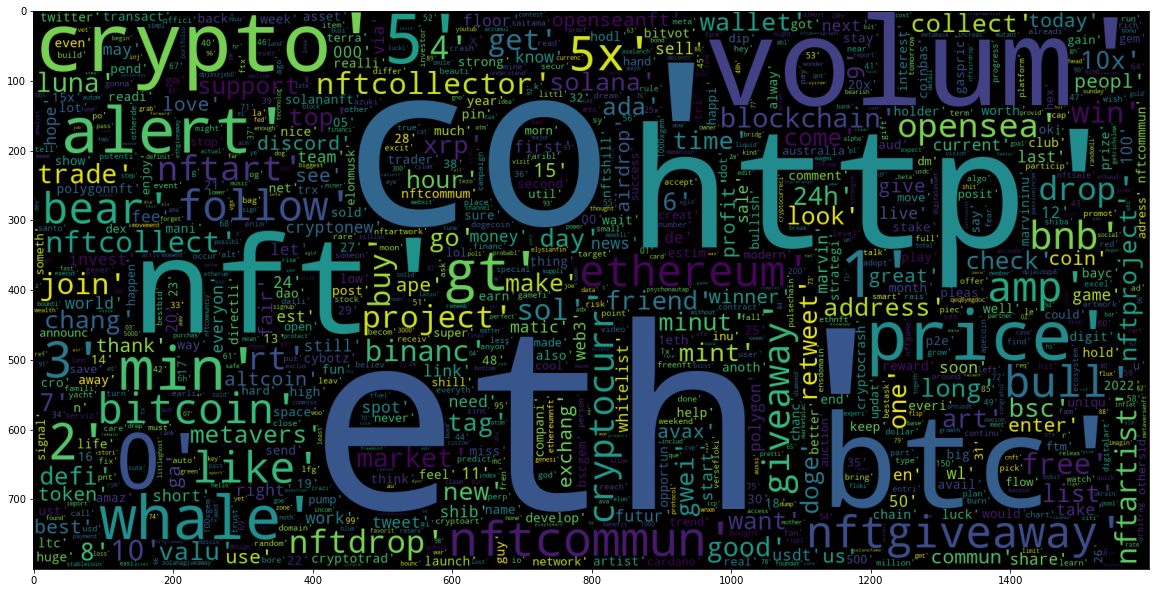

In [40]:
positive = eth_pos['cleaned']
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(positive))
plt.imshow(wc)

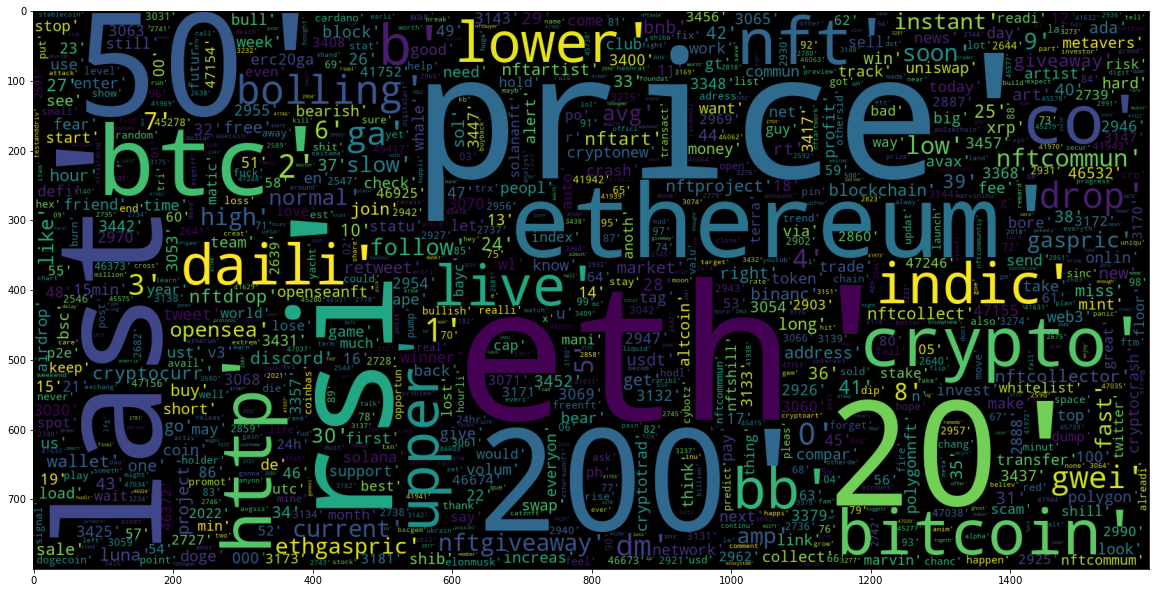

In [41]:
negative = eth_neg['cleaned']
plt.figure(figsize = (20,20))
wc2 = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(negative))
plt.imshow(wc2)

# This section is to extract the value of Ethereum (plus Dodge and Bitcoin)

In [42]:
cg = CoinGeckoAPI()

data = {}
for coin in gecko_list:
    try:
        nested_lists = cg.get_coin_market_chart_range_by_id(
            id=coin,vs_currency='aud',from_timestamp='1589807389',to_timestamp='1652879389'
        )["prices"]
        data[coin] = {}
        data[coin]["timestamps"], data[coin]["values"], = zip(*nested_lists)

    except Exception as e:
        print(e)
        print("coin: " + coin)

frame_list = [
    pd.DataFrame(data[coin]["values"],data[coin]["timestamps"], columns=[coin])
    for coin in gecko_list
    if coin in data
]

In [43]:
df_cryptocurrency = pd.concat(frame_list, axis=1)

In [44]:
df_cryptocurrency["datetime"] = pd.to_datetime(df_cryptocurrency.index, unit="ms")
df_cryptocurrency["date"] = df_cryptocurrency["datetime"].dt.date
df_cryptocurrency["hour"] = df_cryptocurrency["datetime"].dt.hour
df_cryptocurrency.dropna(inplace=True)

In [45]:
renamed= df_cryptocurrency.rename(columns={'bitcoin': 'bitcoin_price','ethereum': 'ethereum_price','dogecoin':'dogecoin_price','date': 'date'})

In [46]:
crypto = renamed.drop(['datetime', 'hour'], axis = 1)

In [47]:
crypto.reset_index(inplace=True)
crypto = crypto.drop(['index'], axis = 1)
crypto['date'] = pd.to_datetime(crypto['date'])
crypto['date'] = crypto['date'].dt.strftime('%Y-%m-%d')
crypto

,bitcoin_price,ethereum_price,dogecoin_price,date
0,14884.979992,328.653136,0.003901,2020-05-19
1,14922.865925,326.538524,0.003891,2020-05-20
2,14452.798040,318.473767,0.003781,2020-05-21
3,13795.940128,302.899061,0.003681,2020-05-22
4,13971.494350,315.525952,0.003858,2020-05-23
...,...,...,...,...
725,42267.741872,2898.843244,0.127568,2022-05-14
726,43534.739233,2976.736395,0.129823,2022-05-15
727,45069.769903,3089.689306,0.134079,2022-05-16
728,42910.751665,2905.144652,0.126187,2022-05-17


In [48]:
crypto['Change ETH'] = crypto.ethereum_price - crypto.ethereum_price.shift(1)
crypto

,bitcoin_price,ethereum_price,dogecoin_price,date,Change ETH
0,14884.979992,328.653136,0.003901,2020-05-19,NaN
1,14922.865925,326.538524,0.003891,2020-05-20,-2.114613
2,14452.798040,318.473767,0.003781,2020-05-21,-8.064757
3,13795.940128,302.899061,0.003681,2020-05-22,-15.574706
4,13971.494350,315.525952,0.003858,2020-05-23,12.626890
...,...,...,...,...,...
725,42267.741872,2898.843244,0.127568,2022-05-14,37.065846
726,43534.739233,2976.736395,0.129823,2022-05-15,77.893151
727,45069.769903,3089.689306,0.134079,2022-05-16,112.952912
728,42910.751665,2905.144652,0.126187,2022-05-17,-184.544654


In [49]:
crypto['ETH Up/Down'] = np.where(crypto['Change ETH']>0, 1, 0)
crypto

,bitcoin_price,ethereum_price,dogecoin_price,date,Change ETH,ETH Up/Down
0,14884.979992,328.653136,0.003901,2020-05-19,NaN,0
1,14922.865925,326.538524,0.003891,2020-05-20,-2.114613,0
2,14452.798040,318.473767,0.003781,2020-05-21,-8.064757,0
3,13795.940128,302.899061,0.003681,2020-05-22,-15.574706,0
4,13971.494350,315.525952,0.003858,2020-05-23,12.626890,1
...,...,...,...,...,...,...
725,42267.741872,2898.843244,0.127568,2022-05-14,37.065846,1
726,43534.739233,2976.736395,0.129823,2022-05-15,77.893151,1
727,45069.769903,3089.689306,0.134079,2022-05-16,112.952912,1
728,42910.751665,2905.144652,0.126187,2022-05-17,-184.544654,0


# Calculate the where the average sentiment overall per day was positive or negative and combine with the ETH table on price going up/down

In [50]:
eth_sentiment = eth.groupby('date')['comp'].mean()
eth_sentiment = eth_sentiment.reset_index()
eth_sentiment

,date,comp
0,2022-05-01,0.070634
1,2022-05-02,0.093398
2,2022-05-03,0.078131
3,2022-05-04,0.075955
4,2022-05-05,0.079205
5,2022-05-06,0.086177
6,2022-05-07,0.061135
7,2022-05-08,0.083538
8,2022-05-09,0.079939
9,2022-05-10,0.078844


In [51]:
eth_sentiment['Pos/Neg'] = np.where(eth_sentiment['comp']>0, 1, 0)

In [52]:
eth_sentiment_move = pd.merge(eth_sentiment, crypto,how='outer', on='date')

In [53]:
eth_sentiment_move.dropna(subset=['comp'])

,date,comp,Pos/Neg,bitcoin_price,ethereum_price,dogecoin_price,Change ETH,ETH Up/Down
0,2022-05-01,0.070634,1.0,53518.018858,3874.650573,0.180779,-112.235667,0
1,2022-05-02,0.093398,1.0,54531.860549,4008.085357,0.188247,133.434784,1
2,2022-05-03,0.078131,1.0,54709.645087,4059.288782,0.186066,51.203425,1
3,2022-05-04,0.075955,1.0,53180.614016,3921.344785,0.182778,-137.943997,0
4,2022-05-05,0.079205,1.0,54702.555595,4053.948028,0.187391,132.603243,1
5,2022-05-06,0.086177,1.0,51400.311798,3866.281839,0.180483,-187.666189,0
6,2022-05-07,0.061135,1.0,51026.289235,3814.224690,0.180969,-52.057149,0
7,2022-05-08,0.083538,1.0,50259.004275,3731.605078,0.180549,-82.619612,0
8,2022-05-09,0.079939,1.0,48329.555540,3571.264784,0.176215,-160.340294,0
9,2022-05-10,0.078844,1.0,43512.077206,3234.184510,0.151046,-337.080274,0


In [54]:
eth_clean = eth_sentiment_move.drop(columns=['bitcoin_price', 'dogecoin_price'])
eth_clean1 = eth_clean.dropna(subset=['comp'])

In [55]:
eth_clean1

,date,comp,Pos/Neg,ethereum_price,Change ETH,ETH Up/Down
0,2022-05-01,0.070634,1.0,3874.650573,-112.235667,0
1,2022-05-02,0.093398,1.0,4008.085357,133.434784,1
2,2022-05-03,0.078131,1.0,4059.288782,51.203425,1
3,2022-05-04,0.075955,1.0,3921.344785,-137.943997,0
4,2022-05-05,0.079205,1.0,4053.948028,132.603243,1
5,2022-05-06,0.086177,1.0,3866.281839,-187.666189,0
6,2022-05-07,0.061135,1.0,3814.224690,-52.057149,0
7,2022-05-08,0.083538,1.0,3731.605078,-82.619612,0
8,2022-05-09,0.079939,1.0,3571.264784,-160.340294,0
9,2022-05-10,0.078844,1.0,3234.184510,-337.080274,0


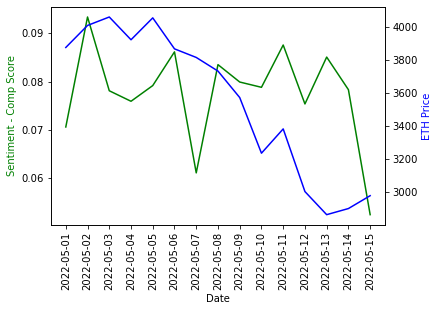

In [56]:
x = eth_clean1["date"]
y1 = eth_clean1["comp"]
y2 = eth_clean1["ethereum_price"]


fig, ax1 = plt.subplots()
plt.xticks(rotation = 90)
ax2 = ax1.twinx()


ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment - Comp Score', color='g')
ax2.set_ylabel('ETH Price', color='b')

plt.show()

# Sentiment Analysis - Starts Here

In [197]:
eth['Pos/Neg'] = np.where(eth['comp']>0, 1, 0)
eth1 = eth.drop(columns=["Unnamed: 0"], axis = 1)
eth1

,date,cleaned,negative,neutral,positive,comp,Pos/Neg
0,2022-05-01,"['eth', 'http', 'co', 'nolnum7c3k']",0.000,1.000,0.000,0.0000,0
1,2022-05-01,"['btc', 'xrp', 'xem', 'lisk', 'iost', 'sand', ...",0.000,0.725,0.275,0.5859,1
2,2022-05-01,"['eth', 'son', '3', 'dip', 'daha', 'yapacak', ...",0.000,1.000,0.000,0.0000,0
3,2022-05-01,"['tigray', 'emerg', 'famin', 'food', 'insecur'...",0.000,1.000,0.000,0.0000,0
4,2022-05-01,"['b', 'nu', 'binanc', 'live', 'nft', 'bnb', 'b...",0.000,1.000,0.000,0.0000,0
...,...,...,...,...,...,...,...
160011,2022-05-15,"['good', 'morn', 'crowd', 'nice', 'sunday', 'n...",0.000,0.612,0.388,0.6908,1
160012,2022-05-15,"['curat', 'coin', 'metric', 'everi', 'day', 'e...",0.000,1.000,0.000,0.0000,0
160013,2022-05-15,"['pari', '3', '1', '1', '10eth', 'belong', 'tr...",0.000,1.000,0.000,0.0000,0
160014,2022-05-15,"['woman', 'maiprisin', 'http', 'co', 'gkcg5g6d...",0.000,1.000,0.000,0.0000,0


In [198]:
eth1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160016 entries, 0 to 160015
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   date      160016 non-null  object 
 1   cleaned   160016 non-null  object 
 2   negative  160016 non-null  float64
 3   neutral   160016 non-null  float64
 4   positive  160016 non-null  float64
 5   comp      160016 non-null  float64
 6   Pos/Neg   160016 non-null  int32  
dtypes: float64(4), int32(1), object(2)
memory usage: 7.9+ MB


In [199]:
eth1.dtypes

date         object
cleaned      object
negative    float64
neutral     float64
positive    float64
comp        float64
Pos/Neg       int32
dtype: object

In [200]:
np.sum(eth1.isnull().any(axis=1))

0

In [201]:
print('Count of columns in the data is: ', len(eth1.columns))
print('Count of rows in the data is: ', len(eth1))

Count of columns in the data is:  7
Count of rows in the data is:  160016


In [202]:
eth1['Pos/Neg'].unique()

array([0, 1])

In [203]:
eth1['Pos/Neg'].nunique()

2

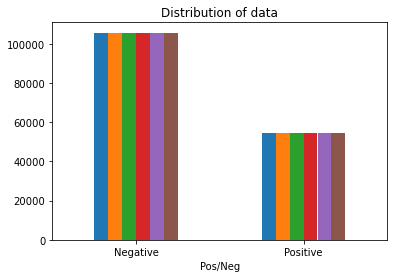

In [204]:
# Plotting the distribution for dataset.
ax = eth1.groupby('Pos/Neg').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
text, sentiment = list(eth1['cleaned']), list(eth1['Pos/Neg'])

<AxesSubplot:xlabel='Pos/Neg', ylabel='count'>

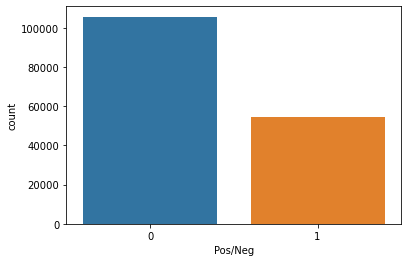

In [205]:
import seaborn as sns
sns.countplot(x='Pos/Neg', data=eth1)

In [206]:
data = eth1[['cleaned', 'Pos/Neg']]
data

,cleaned,Pos/Neg
0,"['eth', 'http', 'co', 'nolnum7c3k']",0
1,"['btc', 'xrp', 'xem', 'lisk', 'iost', 'sand', ...",1
2,"['eth', 'son', '3', 'dip', 'daha', 'yapacak', ...",0
3,"['tigray', 'emerg', 'famin', 'food', 'insecur'...",0
4,"['b', 'nu', 'binanc', 'live', 'nft', 'bnb', 'b...",0
...,...,...
160011,"['good', 'morn', 'crowd', 'nice', 'sunday', 'n...",1
160012,"['curat', 'coin', 'metric', 'everi', 'day', 'e...",0
160013,"['pari', '3', '1', '1', '10eth', 'belong', 'tr...",0
160014,"['woman', 'maiprisin', 'http', 'co', 'gkcg5g6d...",0


In [207]:
data['Pos/Neg'].unique()

array([0, 1])

In [208]:
#Separating the postivie and negative tweets
data_pos = data[data['Pos/Neg'] == 1]
data_neg = data[data['Pos/Neg'] == 0]

In [209]:
data_pos = data_pos.iloc[:int(130000)]
data_neg = data_neg.iloc[:int(130000)]

In [210]:
dataset = pd.concat([data_pos, data_neg])
dataset

,cleaned,Pos/Neg
1,"['btc', 'xrp', 'xem', 'lisk', 'iost', 'sand', ...",1
6,"['4', 'hour', 'top', 'mover', 'report', 'block...",1
7,"['degousdt', 'bear', 'alert', '5x', 'volum', '...",1
9,"['everyon', 'good', 'weekend', 'nftcommun', 'n...",1
12,"['nft', 'collab', 'degenladybug', 'x', 'thelot...",1
...,...,...
160008,"['bitcoin', 'last', 'price', '29658', 'btc', '...",0
160012,"['curat', 'coin', 'metric', 'everi', 'day', 'e...",0
160013,"['pari', '3', '1', '1', '10eth', 'belong', 'tr...",0
160014,"['woman', 'maiprisin', 'http', 'co', 'gkcg5g6d...",0


In [211]:
dataset['cleaned']=dataset['cleaned'].str.lower()
dataset['cleaned'].tail()

160008    ['bitcoin', 'last', 'price', '29658', 'btc', '...
160012    ['curat', 'coin', 'metric', 'everi', 'day', 'e...
160013    ['pari', '3', '1', '1', '10eth', 'belong', 'tr...
160014    ['woman', 'maiprisin', 'http', 'co', 'gkcg5g6d...
160015    ['bitcoin', 'last', 'price', '29629', 'btc', '...
Name: cleaned, dtype: object

In [212]:
##Cleaning and removing STOPWORDS

stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [213]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['cleaned'] = dataset['cleaned'].apply(lambda text: cleaning_stopwords(text))
dataset['cleaned'].head()

1     ['btc', 'xrp', 'xem', 'lisk', 'iost', 'sand', ...
6     ['4', 'hour', 'top', 'mover', 'report', 'block...
7     ['degousdt', 'bear', 'alert', '5x', 'volum', '...
9     ['everyon', 'good', 'weekend', 'nftcommun', 'n...
12    ['nft', 'collab', 'degenladybug', 'x', 'thelot...
Name: cleaned, dtype: object

In [214]:
#Cleaning and removing punctuations
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['cleaned']= dataset['cleaned'].apply(lambda x: cleaning_punctuations(x))
dataset['cleaned'].tail()

160008    bitcoin last price 29658 btc daili indic rsi 2...
160012    curat coin metric everi day eth 2019 usd 0 6 m...
160013    pari 3 1 1 10eth belong travel nft collect nft...
160014    woman maiprisin http co gkcg5g6dwv foundat fnd...
160015    bitcoin last price 29629 btc daili indic rsi 2...
Name: cleaned, dtype: object

In [215]:
#Cleaning and removing repeating characters
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['cleaned'] = dataset['cleaned'].apply(lambda x: cleaning_repeating_char(x))
dataset['cleaned'].tail()

160008    bitcoin last price 29658 btc daili indic rsi 2...
160012    curat coin metric everi day eth 219 usd 0 6 mr...
160013    pari 31110eth belong travel nft collect nftcom...
160014    woman maiprisin http co gkcg5g6dwv foundat fnd...
160015    bitcoin last price 29629 btc daili indic rsi 2...
Name: cleaned, dtype: object

In [216]:
#Cleaning and removing URLs
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['cleaned'] = dataset['cleaned'].apply(lambda x: cleaning_URLs(x))
dataset['cleaned'].tail()

160008    bitcoin last price 29658 btc daili indic rsi 2...
160012    curat coin metric everi day eth 219 usd 0 6 mr...
160013    pari 31110eth belong travel nft collect nftcom...
160014    woman maiprisin http co gkcg5g6dwv foundat fnd...
160015    bitcoin last price 29629 btc daili indic rsi 2...
Name: cleaned, dtype: object

In [217]:
#Cleaning numbers out
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['cleaned'] = dataset['cleaned'].apply(lambda x: cleaning_numbers(x))
dataset['cleaned'].tail()

160008    bitcoin last price  btc daili indic rsi       ...
160012    curat coin metric everi day eth  usd   mrkt do...
160013    pari eth belong travel nft collect nftcommun n...
160014    woman maiprisin http co gkcggdwv foundat fnd w...
160015    bitcoin last price  btc daili indic rsi       ...
Name: cleaned, dtype: object

In [218]:
#appllying stemming
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['cleaned']= dataset['cleaned'].apply(lambda x: stemming_on_text(x))
dataset['cleaned'].head()

1        btc xrp xem lisk iost sand trx btt win sfp eth
6      hour top mover report blockchain crypto crypt...
7     degousdt bear alert x volum price    min  volu...
9     everyon good weekend nftcommun nft eth glitchn...
12    nft collab degenladybug x thelottonft partner ...
Name: cleaned, dtype: object

In [219]:
#applying lemmatizer
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['cleaned'] = dataset['cleaned'].apply(lambda x: lemmatizer_on_text(x))
dataset['cleaned'].head()

1        btc xrp xem lisk iost sand trx btt win sfp eth
6      hour top mover report blockchain crypto crypt...
7     degousdt bear alert x volum price    min  volu...
9     everyon good weekend nftcommun nft eth glitchn...
12    nft collab degenladybug x thelottonft partner ...
Name: cleaned, dtype: object

In [222]:
X=dataset.cleaned
y=dataset["Pos/Neg"]

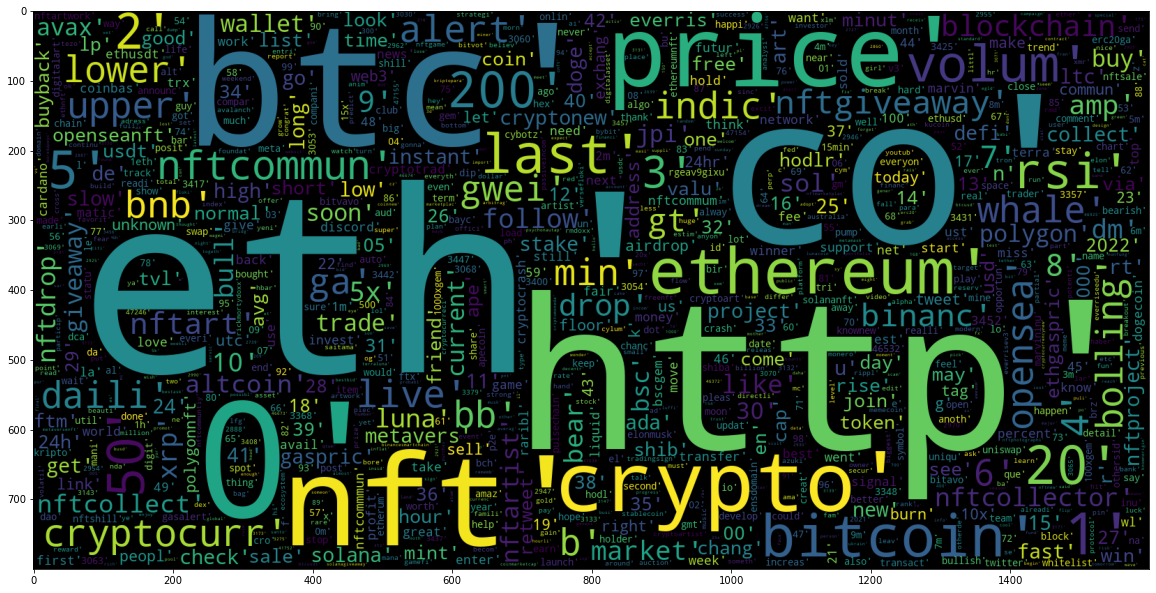

In [223]:
data_neg = data['cleaned'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

In [227]:
data_pos = data['cleaned'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

ValueError: We need at least 1 word to plot a word cloud, got 0.

In [233]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =42)

In [229]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  500000


In [230]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [231]:
def model_Evaluate(model):
# Predict values for Test dataset
y_pred = model.predict(X_test)
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))
# Compute and plot the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
categories = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

IndentationError: expected an indented block (<ipython-input-231-f109ed9ca2b4>, line 3)

In [234]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

ValueError: could not convert string to float: 'phausdt bear alert x volum price    min   volum   crypto whale btc eth pha pha http co plzzbkuvag'

In [ ]:
eth_pos_avg = eth.groupby('date')['positive'].mean()
eth_pos_avg = eth_pos_avg.reset_index()
eth_pos_avg

In [ ]:
eth_neg_avg = eth.groupby('date')['negative'].mean()
eth_neg_avg = eth_neg_avg.reset_index()
eth_neg_avg.head()

In [ ]:
plt.plot(eth_pos_avg['date'],eth_pos_avg["positive"], linestyle = 'solid')
plt.plot(eth_neg_avg['date'],eth_neg_avg["negative"], linestyle = 'solid', color = "red")
plt.xticks(rotation = 90)
plt.figure().set_figwidth(1000)
plt.show()